In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyfaidx import Fasta
from goatools.semantic import TermCounts
from goatools.associations import dnld_assc
from goatools.obo_parser import GODag
from IPython.display import Image, display
from pathlib import Path

### GO terms

In [2]:
train = '../cafa5/train/train_sequences.fasta'
test = '../cafa5/test/testsuperset.fasta'

../cafa5/train/go-basic.obo: fmt(1.2) rel(2023-01-01) 46,739 Terms
HMS:0:00:03.075832 235,582 annotations READ: /Users/xiheng/Workspace/prostT5-CLIP/notebooks/tair.gaf 
24425 IDs in loaded association branch, BP


lineage info for terms ['GO:0097192'] written to GO_lineage.png


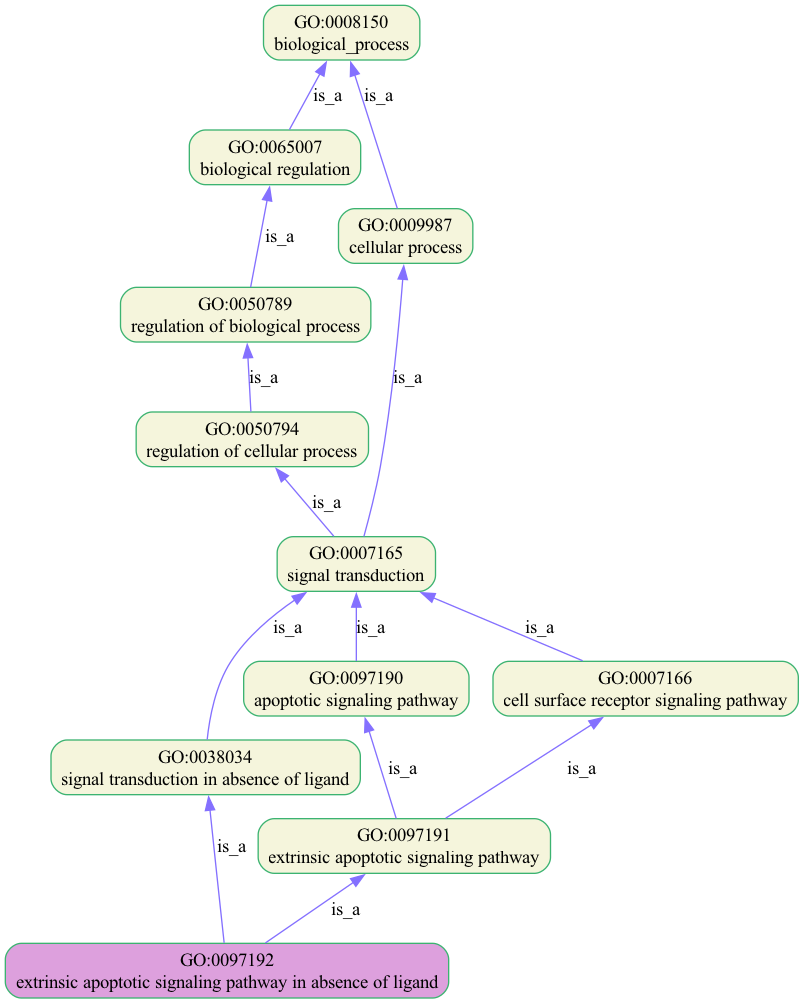

In [ ]:
godag = GODag("../cafa5/train/go-basic.obo")
fin_gaf = os.path.join(os.getcwd(), "tair.gaf")
associations = dnld_assc(fin_gaf, godag)
termcounts = TermCounts(godag, associations) 
go_id= 'GO:0097192'
rec = godag[go_id]
lineage_png = 'GO_lineage.png'
godag.draw_lineage([rec] )
display(Image(lineage_png, width=600, height=300))

In [3]:
Train_terms = pd.read_csv('../cafa5/train/train_terms.tsv',sep="\t")
print("Training data available :",Train_terms.shape[0])
NumProteins=Train_terms["EntryID"].unique()
pd.DataFrame(Train_terms.head(5))

Training data available : 5363863


,EntryID,term,aspect
0,A0A009IHW8,GO:0008152,BPO
1,A0A009IHW8,GO:0034655,BPO
2,A0A009IHW8,GO:0072523,BPO
3,A0A009IHW8,GO:0044270,BPO
4,A0A009IHW8,GO:0006753,BPO


Text(0, 0.5, 'Count')

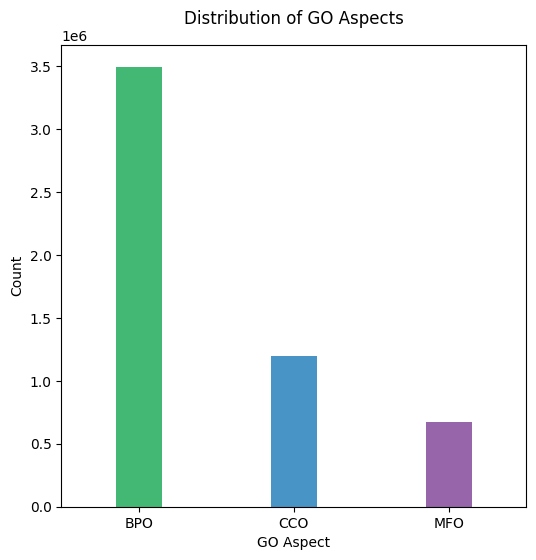

In [7]:
plt.figure(figsize=(6, 6))

ax = sns.countplot(data=Train_terms,
                  x='aspect',
                  hue='aspect',
                  palette=['#2ecc71', '#3498db', '#9b59b6'],
                  legend=False,
                  width=0.3);

ax.set_title('Distribution of GO Aspects', pad=15)
ax.set_xlabel('GO Aspect')
ax.set_ylabel('Count')

GO Terms per Protein Statistics:
count    142246.000000
mean         37.708357
std          42.524701
min           2.000000
25%          10.000000
50%          24.000000
75%          50.000000
max         815.000000
Name: term, dtype: float64

Top 5 proteins with most GO terms:
EntryID
Q02248    815
Q62226    736
Q01705    721
P22725    709
P01137    668
Name: term, dtype: int64

Percentile distribution:
0.25     10.0
0.50     24.0
0.75     50.0
0.90     85.0
0.95    116.0
0.99    206.0
Name: term, dtype: float64


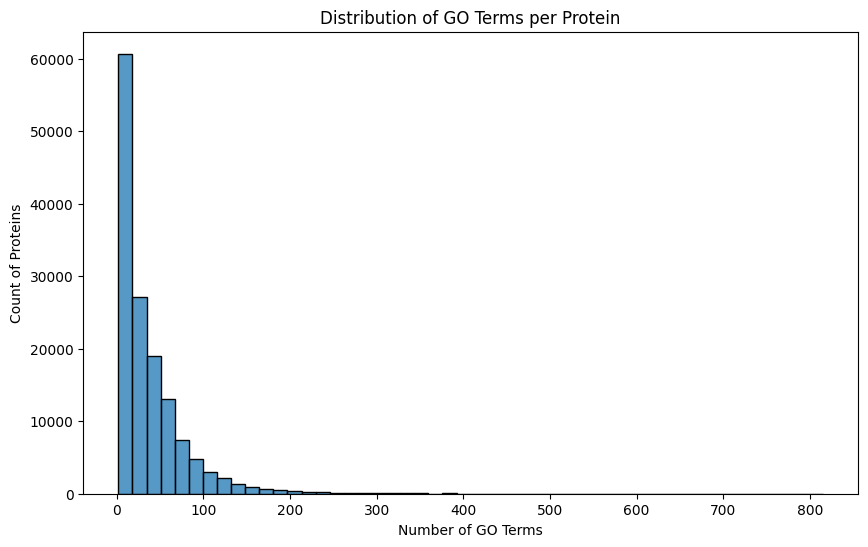

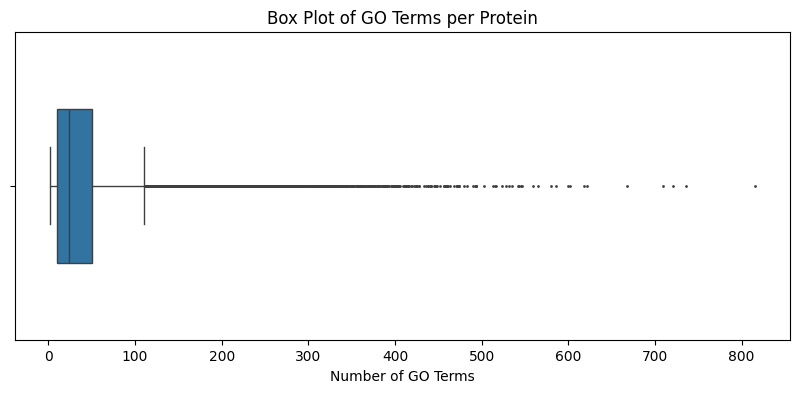

In [30]:
terms_per_protein = Train_terms.groupby('EntryID')['term'].count()

# Basic statistics
print("GO Terms per Protein Statistics:")
print(terms_per_protein.describe())

# Create distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(terms_per_protein, bins=50)
plt.title('Distribution of GO Terms per Protein')
plt.xlabel('Number of GO Terms')
plt.ylabel('Count of Proteins')

plt.figure(figsize=(10, 4))
sns.boxplot(x=terms_per_protein, width=0.5, fliersize=1)
plt.title('Box Plot of GO Terms per Protein')
plt.xlabel('Number of GO Terms')

print("\nTop 5 proteins with most GO terms:")
print(terms_per_protein.nlargest(5))

print("\nPercentile distribution:")
percentiles = [25, 50, 75, 90, 95, 99]
print(terms_per_protein.quantile(np.array(percentiles)/100))

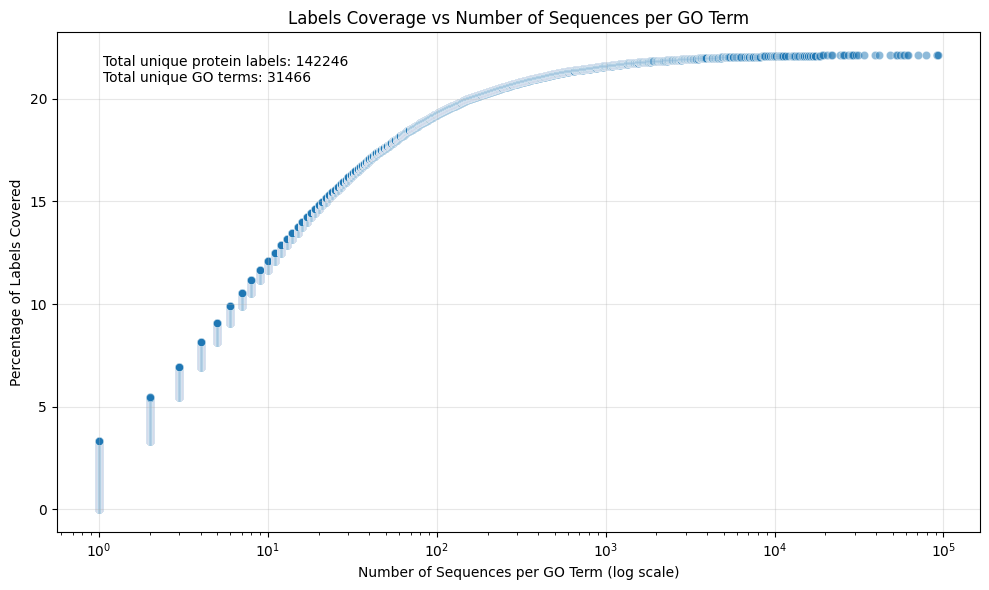

In [ ]:
protein_labels = Train_terms.groupby('EntryID')['term'].agg(set)

# Count how many sequences each GO term appears in
go_term_sequence_counts = {}
for protein, terms in protein_labels.items():
    for term in terms:
        go_term_sequence_counts[term] = go_term_sequence_counts.get(term, 0) + 1

sequence_counts = pd.Series(go_term_sequence_counts).sort_values()

total_labels = len(protein_labels)  # Total number of unique protein labels
cumulative_percentage = np.arange(1, len(sequence_counts) + 1) / total_labels * 100

plt.figure(figsize=(10, 6))
sns.scatterplot(x=sequence_counts.values, y=cumulative_percentage, alpha=0.5)
plt.xscale('log')
plt.title('Labels Coverage vs Number of Sequences per GO Term')
plt.xlabel('Number of Sequences per GO Term (log scale)')
plt.ylabel('Percentage of Labels Covered')
plt.grid(True, alpha=0.3)

plt.text(0.05, 0.90, 
         f'Total unique protein labels: {total_labels}\n'
         f'Total unique GO terms: {len(sequence_counts)}',
         transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

### Taxonomy

Basic Statistics:
Total entries: 142246
Unique taxonomy IDs: 3156

Percentage distribution:
taxonomyID
9606      17.66
3702      10.17
10090     10.11
7955       8.91
7227       8.45
          ...  
53326      0.00
442563     0.00
306901     0.00
47145      0.00
29892      0.00
Name: count, Length: 3156, dtype: float64


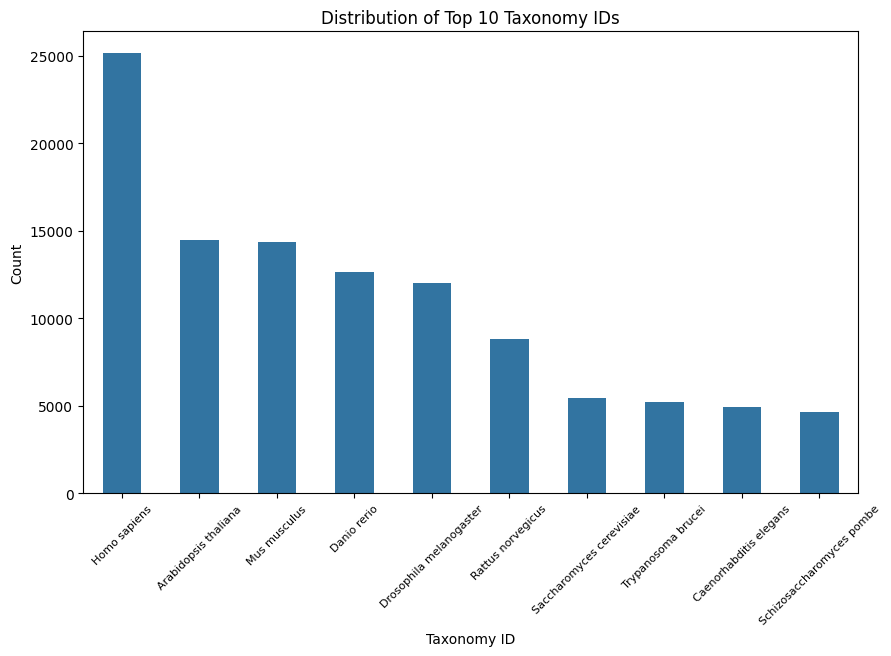

In [ ]:
tax = pd.read_csv('../cafa5/train/train_taxonomy.tsv',sep="\t")
print("Basic Statistics:")
print(f"Total entries: {len(tax)}")
print(f"Unique taxonomy IDs: {tax['taxonomyID'].nunique()}")

taxonomy_names = {
    9606: 'Homo sapiens',
    10090: 'Mus musculus',
    7227: 'Drosophila melanogaster',
    559292: 'Saccharomyces cerevisiae',
    3702: 'Arabidopsis thaliana',
    6239: 'Caenorhabditis elegans',
    7955: 'Danio rerio',
    10116: 'Rattus norvegicus',
    185431: 'Trypanosoma brucei',
    284812: 'Schizosaccharomyces pombe'
}

# Count distribution
tax_counts = tax['taxonomyID'].value_counts()

top_tax_ids = tax_counts.index[:10]
top_tax_names = [taxonomy_names.get(tax_id, "Unknown") for tax_id in top_tax_ids]


# Create bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_tax_names, y=tax_counts.values[:10], width=0.5)
plt.title('Distribution of Top 10 Taxonomy IDs')
plt.xticks(rotation=45, fontsize=8)
plt.xlabel('Taxonomy ID')
plt.ylabel('Count')

print("\nPercentage distribution:")
print((tax_counts / len(tax) * 100).round(2))

### MMseqs2 Clustering

In [16]:
train_sequences = Path('../cafa5/train/train_sequences.fasta')
test_sequences = Path('../cafa5/test/testsuperset.fasta')

# Load the clustered sequences
train_clustered = Path('../clusters/train_rep_seq.fasta')
test_clustered = Path('../clusters/test_rep_seq.fasta')

num_train = len(Fasta(train_sequences).keys())
num_test = len(Fasta(test_sequences).keys())
num_train_clu = len(Fasta(train_clustered).keys())
num_test_clu = len(Fasta(test_clustered).keys())

print(f"train set has {num_train} and {num_train_clu} sequences after redundancy reduction")
print(f"test set has {num_test} and {num_test_clu} sequences after redundancy reduction")

train set has 142246 and 61565 sequences after redundancy reduction
test set has 141864 and 70823 sequences after redundancy reduction


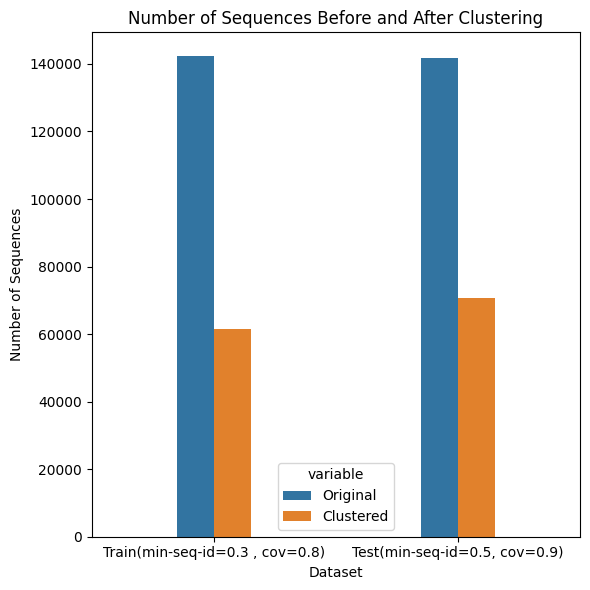

In [23]:
data = {
    'Dataset': ['Train(min-seq-id=0.3 , cov=0.8)', 'Test(min-seq-id=0.5, cov=0.9)'],
    'Original': [num_train, num_test],
    'Clustered': [num_train_clu, num_test_clu]
}
df = pd.DataFrame(data)

plt.figure(figsize=(6, 6))
ax = sns.barplot(x='Dataset', y='value', hue='variable', data=pd.melt(df, ['Dataset']), width=0.3)
plt.title('Number of Sequences Before and After Clustering')
plt.xlabel('Dataset')
plt.ylabel('Number of Sequences')

plt.tight_layout()
plt.show()